In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import transforms

from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from utils.attacks import fgsm, pgd
from utils.utils import plot_images
from utils.train_utils import train, adv_train
from utils.trainer import ModelTrainer, plot_history
from models.resnet import ResNet, SparseResNet
from models.wide_resnet import WideResNet, SparseWideResNet
from models.resnet_FReLU import FResNet, FSparseResNet

1.7.0
True


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt

def test_epoch(model, loader, loss_fn, device=torch.device("cuda")):
    """Standard evaluation epoch over the dataset"""
    total_loss, accuracy = 0., 0.
    with torch.no_grad():
        for k, (X, y) in enumerate(loader, 1):
            start = dt.now().replace(microsecond=0)
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            
            total_loss += loss.data.item() * X.size(0)
            accuracy += (outputs.argmax(dim=1) == y).sum().item()
            end = dt.now().replace(microsecond=0)
            print(f"test iteration: {k}/{len(loader)} time: {end-start}", end="\r")
        print(" " * 80, end="\r")
    return total_loss / len(loader.dataset), accuracy / len(loader.dataset)

def clean_acc(model, loader):
    clean_correct = 0
    for k, (X, y) in enumerate(loader, 1):
        start = dt.now().replace(microsecond=0)
        X, y = X.to(device), y.to(device)  
        clean_correct += (model(X).argmax(dim=1) == y).sum().item()
        end = dt.now().replace(microsecond=0)
        print(f"iter: {k}/{len(loader)} time: {end-start}", end="\r")
    print(" " * 50, end="\r")
    return round(clean_correct / len(loader.dataset), 4)

def adv_acc(model, loader, loss_fn, attack, attack_params):
    adv_correct = [0] * len(attack_params)
    for i, p in enumerate(attack_params):
        for k, (X, y) in enumerate(loader, 1):
            start = dt.now().replace(microsecond=0)
            X, y = X.to(device), y.to(device)
            noise = attack(model, X, y, loss_fn, epsilon=p["epsilon"], 
                                  alpha=p["alpha"], num_iter=p["num_iter"])
            adv_correct[i] += (model(X+noise).argmax(dim=1) == y).sum().item()
            end = dt.now().replace(microsecond=0)
            print(f"iter: {k}/{len(loader)} time: {end-start}", end="\r")
        print(" " * 50, end="\r")
        print(f"name: {p['name']} accuracy: {adv_correct[i] / len(loader.dataset)}")
    return [round(a/len(loader.dataset), 4) for a in adv_correct]

def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
#             ax[i][j].imshow(X[i*N+j].cpu().detach().permute(1,2,0))
            
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

In [19]:
tr_transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
vl_transform = transforms.Compose([
    transforms.ToTensor()
])

ds = MNIST('../data', train=True, download=True, transform=tr_transform)
ds_test = MNIST('../data', train=False, download=True, transform=vl_transform)

batch_size = 100
train_dl = DataLoader(ds, batch_size, shuffle=True)
valid_dl = DataLoader(ds_test, batch_size, shuffle=True)
test_loader = DataLoader(ds_test, 20, shuffle=False)

for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    break

In [6]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

cuda
Epoch: 1 Validation Loss: 0.4815 accuracy: 0.8409, time: 0:00:16                
Epoch: 2 Validation Loss: 0.4028 accuracy: 0.8578, time: 0:00:17                
Epoch: 3 Validation Loss: 0.3877 accuracy: 0.8587, time: 0:00:16                
Epoch: 4 Validation Loss: 0.3601 accuracy: 0.8669, time: 0:00:16                
Epoch: 5 Validation Loss: 0.3624 accuracy: 0.8660, time: 0:00:16                
epochs_no_improve: 1/5
Epoch: 6 Validation Loss: 0.3488 accuracy: 0.8718, time: 0:00:17                
Epoch: 7 Validation Loss: 0.3349 accuracy: 0.8734, time: 0:00:16                
Epoch: 8 Validation Loss: 0.3473 accuracy: 0.8694, time: 0:00:16                
epochs_no_improve: 1/5
Epoch: 9 Validation Loss: 0.3316 accuracy: 0.8752, time: 0:00:17                
Epoch: 10 Validation Loss: 0.3294 accuracy: 0.8761, time: 0:00:16               
Epoch: 11 Validation Loss: 0.3263 accuracy: 0.8751, time: 0:00:16               
Epoch: 12 Validation Loss: 0.3339 accuracy: 0.8742, time: 

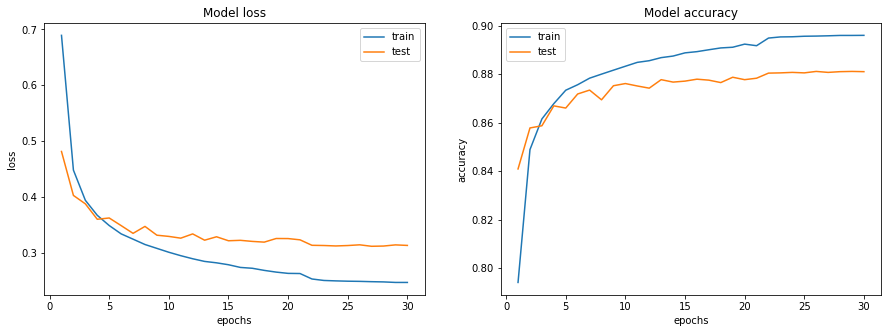

In [9]:
trainer = ModelTrainer(ds, ds_test, is_sparse=False, batch_size=100)

model = Net1()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

history = trainer.train(model, loss_fn, optimizer, scheduler, epochs=30, patience=5)
plot_history(history)
torch.save(model.state_dict(), "../saved/net1.pt")

In [7]:
model = Net1().to(device)
model.load_state_dict(torch.load("../saved/net1.pt", map_location=device))

<All keys matched successfully>

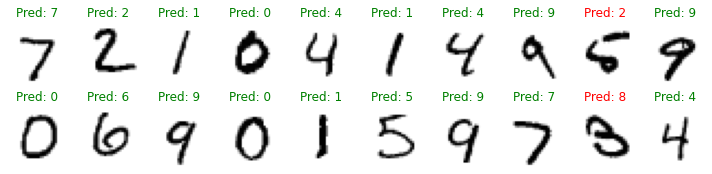

In [12]:
plot_images(X, y, model(X), 2, 10)

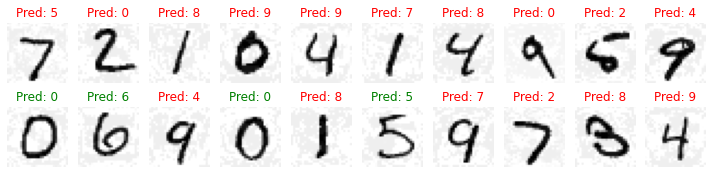

In [13]:
noise = pgd(model, X, y, nn.CrossEntropyLoss(), epsilon=16/255, alpha=2/255, num_iter=10)
adv_ex = X+noise
plot_images(adv_ex, y, model(adv_ex), 2, 10)

cuda
Epoch: 1 Validation Loss: 0.9157 accuracy: 0.7237, time: 0:00:33                
Epoch: 2 Validation Loss: 0.7644 accuracy: 0.7559, time: 0:00:33                
Epoch: 3 Validation Loss: 0.6813 accuracy: 0.7802, time: 0:00:33                
Epoch: 4 Validation Loss: 0.6497 accuracy: 0.7834, time: 0:00:32                
Epoch: 5 Validation Loss: 0.6326 accuracy: 0.7907, time: 0:00:33                
Epoch: 6 Validation Loss: 0.6079 accuracy: 0.7964, time: 0:00:33                
Epoch: 7 Validation Loss: 0.6019 accuracy: 0.7985, time: 0:00:32                
Epoch: 8 Validation Loss: 0.6051 accuracy: 0.7983, time: 0:00:33                
epochs_no_improve: 1/5
Epoch: 9 Validation Loss: 0.5839 accuracy: 0.8036, time: 0:00:33                
Epoch: 10 Validation Loss: 0.5870 accuracy: 0.8064, time: 0:00:32               
epochs_no_improve: 1/5
Epoch: 11 Validation Loss: 0.5695 accuracy: 0.8089, time: 0:00:33               
Epoch: 12 Validation Loss: 0.5684 accuracy: 0.8108, time: 

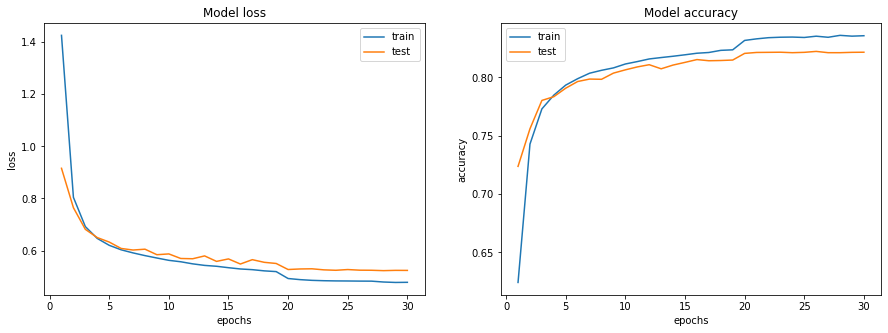

In [14]:
trainer = ModelTrainer(ds, ds_test, is_sparse=False, batch_size=100)
model = Net1()
model.load_state_dict(torch.load("../saved/net1.pt", map_location=device))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

params = {
    "epsilon": 16/255,
    "alpha": 2/255,
    "num_iter": 10
}

history = trainer.adv_train(model, pgd, params, loss_fn, optimizer, scheduler, epochs=30, patience=5)
plot_history(history)
torch.save(model.state_dict(), "../saved/pretrained_robust_net1.pt")

cuda
Epoch: 1 Validation Loss: 1.9563 accuracy: 0.3007, time: 0:00:33                
Epoch: 2 Validation Loss: 1.9193 accuracy: 0.3023, time: 0:00:33                
Epoch: 3 Validation Loss: 1.9135 accuracy: 0.3027, time: 0:00:34                
Epoch: 4 Validation Loss: 1.9095 accuracy: 0.3052, time: 0:00:33                
Epoch: 5 Validation Loss: 1.9053 accuracy: 0.3031, time: 0:00:33                
Epoch: 6 Validation Loss: 1.8967 accuracy: 0.3052, time: 0:00:33                
Epoch: 7 Validation Loss: 1.8941 accuracy: 0.3049, time: 0:00:33                
Epoch: 8 Validation Loss: 1.8888 accuracy: 0.3067, time: 0:00:33                
Epoch: 9 Validation Loss: 1.8876 accuracy: 0.3061, time: 0:00:33                
Epoch: 10 Validation Loss: 1.8929 accuracy: 0.3047, time: 0:00:32               
epochs_no_improve: 1/5
Epoch: 11 Validation Loss: 1.8963 accuracy: 0.3061, time: 0:00:33               
epochs_no_improve: 2/5
Epoch: 12 Validation Loss: 1.8838 accuracy: 0.3059, time: 

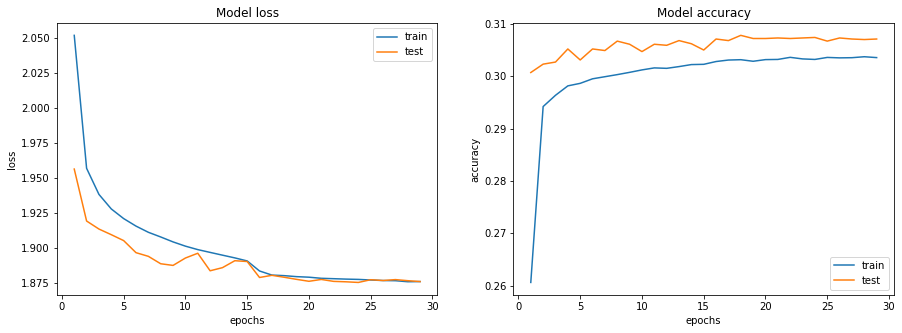

In [32]:
trainer = ModelTrainer(ds, ds_test, is_sparse=False, batch_size=100)
model = Net1()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

params = {
    "epsilon": 16/255,
    "alpha": 2/255,
    "num_iter": 10
}

history = trainer.adv_train(model, pgd, params, loss_fn, optimizer, scheduler, epochs=30, patience=5)
plot_history(history)
torch.save(model.state_dict(), "../saved/robust_net1.pt")

In [33]:
attack = {
    "id": 0,
    "name": "eps=16,a=2,i=10",
    "epsilon": 16/255,
    "alpha": 2/255,
    "num_iter": 10
}

In [34]:
model.load_state_dict(torch.load("../saved/robust_net1.pt", map_location=device))

acc_clean = clean_acc(model, test_loader)
print(f"clean accuracy: {acc_clean}")
acc_adver = adv_acc(model, test_loader, nn.CrossEntropyLoss(), pgd, [attack])

clean accuracy: 0.3111                            
name: eps=16,a=2,i=10 accuracy: 0.3074            


In [24]:
model.load_state_dict(torch.load("../saved/pretrained_robust_net1.pt", map_location=device))

acc_clean = clean_acc(model, test_loader)
print(f"clean accuracy: {acc_clean}")
acc_adver = adv_acc(model, test_loader, nn.CrossEntropyLoss(), pgd, [attack])

clean accuracy: 0.8798                            
name: eps=16,a=2,i=10 accuracy: 0.8215            


In [26]:
model.load_state_dict(torch.load("../saved/net1.pt", map_location=device))

acc_clean = clean_acc(model, test_loader)
print(f"clean accuracy: {acc_clean}")

clean accuracy: 0.881                             


In [11]:
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class FlattenReLU(torch.autograd.Function):
    @staticmethod
    def forward(self, x, thresholds):
        self.save_for_backward(x, thresholds)
        x = torch.where(x > thresholds, thresholds, x)
        x[x<0] = 0
        return x

    @staticmethod
    def backward(self, grad_output):
        x, thresholds = self.saved_tensors
        x_grad = grad_output.clone()
        x_grad[x>thresholds] = 0
        x_grad[x<0] = 0
        return x_grad, None

FRelu = FlattenReLU.apply

class myLinear(nn.Linear):

    def __init__(self, in_features, out_features, bias=False):
        super().__init__(in_features, out_features, bias)

    def forward(self, x):
        xe = torch.stack([x]*self.weight.size(0), dim=1)
        we = torch.stack([self.weight]*x.size(0), dim=0)
        z, _ = (we * xe).topk(int(0.3*self.weight.size(1)))
        thresholds = z.sum(dim=2)
        x = F.linear(x, self.weight, self.bias)    
        return FRelu(x, thresholds)


In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = myLinear(10, 2, bias=False)
        
    def forward(self, x):
        x = self.fc1(x)
        return x

model = Net()
model

Net(
  (fc1): myLinear(in_features=10, out_features=2, bias=False)
)

In [13]:
w = model.fc1.weight.clone()
w = torch.Tensor([[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1], 
                  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                 ])
x = torch.Tensor([[1,2,3,4,5,6,7,8,9,10], [10,9,-8,-7,-6,-5,4,3,2,1], [6,7,8,9,10,5,4,3,2,1]])
model.fc1.weight.data = w
print(model.fc1.weight.data)
print(x)

tensor([[1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000, 0.2000,
         0.1000],
        [0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
         1.0000]])
tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [10.,  9., -8., -7., -6., -5.,  4.,  3.,  2.,  1.],
        [ 6.,  7.,  8.,  9., 10.,  5.,  4.,  3.,  2.,  1.]])


In [14]:
xe = torch.stack([x]*w.size(0), dim=1)
xe

tensor([[[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
         [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]],

        [[10.,  9., -8., -7., -6., -5.,  4.,  3.,  2.,  1.],
         [10.,  9., -8., -7., -6., -5.,  4.,  3.,  2.,  1.]],

        [[ 6.,  7.,  8.,  9., 10.,  5.,  4.,  3.,  2.,  1.],
         [ 6.,  7.,  8.,  9., 10.,  5.,  4.,  3.,  2.,  1.]]])

In [35]:
we = torch.stack([w]*x.size(0), dim=0)
we

tensor([[[1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000,
          0.2000, 0.1000],
         [0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
          0.9000, 1.0000]],

        [[1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000,
          0.2000, 0.1000],
         [0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
          0.9000, 1.0000]],

        [[1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000,
          0.2000, 0.1000],
         [0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
          0.9000, 1.0000]]])

In [563]:
(we * xe)

tensor([[[ 1.0000,  1.8000,  2.4000,  2.8000,  3.0000,  3.0000,  2.8000,
           2.4000,  1.8000,  1.0000],
         [ 0.1000,  0.4000,  0.9000,  1.6000,  2.5000,  3.6000,  4.9000,
           6.4000,  8.1000, 10.0000]],

        [[10.0000,  8.1000, -6.4000, -4.9000, -3.6000, -2.5000,  1.6000,
           0.9000,  0.4000,  0.1000],
         [ 1.0000,  1.8000, -2.4000, -2.8000, -3.0000, -3.0000,  2.8000,
           2.4000,  1.8000,  1.0000]],

        [[ 6.0000,  6.3000,  6.4000,  6.3000,  6.0000,  2.5000,  1.6000,
           0.9000,  0.4000,  0.1000],
         [ 0.6000,  1.4000,  2.4000,  3.6000,  5.0000,  3.0000,  2.8000,
           2.4000,  1.8000,  1.0000]]])

In [570]:
val, _ = (we * xe).topk(int(0.3*w.size(1)))
print(val)

tensor([[[ 3.0000,  3.0000,  2.8000],
         [10.0000,  8.1000,  6.4000]],

        [[10.0000,  8.1000,  1.6000],
         [ 2.8000,  2.4000,  1.8000]],

        [[ 6.4000,  6.3000,  6.3000],
         [ 5.0000,  3.6000,  3.0000]]])


In [571]:
thresholds = val.sum(dim=-1)
print(thresholds)

tensor([[ 8.8000, 24.5000],
        [19.7000,  7.0000],
        [19.0000, 11.6000]])


In [572]:
res = x @ w.T
f = torch.where(res > thresholds, thresholds, res)
f[f<0]=0
f

tensor([[ 8.8000, 24.5000],
        [ 3.7000,  0.0000],
        [19.0000, 11.6000]])

In [573]:
model(x)

tensor([[ 8.8000, 24.5000],
        [ 3.7000,  0.0000],
        [19.0000, 11.6000]], grad_fn=<FlattenReLUBackward>)

In [574]:
x @ w.T

tensor([[22.0000, 38.5000],
        [ 3.7000, -0.4000],
        [36.5000, 24.0000]])